<a href="https://colab.research.google.com/github/GloriaMoraaRiechi/Spring-2025/blob/main/cse817_question2_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SENTIMENT ANALYSIS WITH PYSPARK**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Sentiment Analysis").getOrCreate()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
import shutil

# Create a .kaggle folder and move the file
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set file permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
# Download the Twitter US Airline Sentiment dataset
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

# Unzip the downloaded dataset
!unzip twitter-airline-sentiment.zip


Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
twitter-airline-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  twitter-airline-sentiment.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Preprocess Text using

In [ ]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col

# Original DataFrame
df = spark.read.csv("Tweets.csv", header=True, inferSchema=True)

# Step 1: Remove rows where 'text' is null
df_clean = df.filter(col("text").isNotNull() & col("airline_sentiment").isNotNull())

# Step 2: Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="filtered")
filteredData = tokenizer.transform(df_clean)

# (Optional) Check for nulls in 'filtered'
filteredData.select(col("filtered").isNull().alias("null_filtered")).groupBy("null_filtered").count().show()

# Step 3: Convert to Pandas
data_pd = filteredData.select("filtered", "airline_sentiment").toPandas()
data_pd["text"] = data_pd["filtered"].apply(lambda x: " ".join(x))


+-------------+-----+
|null_filtered|count|
+-------------+-----+
|        false|14632|
+-------------+-----+



### Convert to TensorFlow-Compatible Format

In [ ]:
# Collect data
filteredData = filteredData.dropna(subset=["filtered", "airline_sentiment"])

data_pd = filteredData.select("filtered", "airline_sentiment").toPandas()
data_pd["text"] = data_pd["filtered"].apply(lambda x: " ".join(x))

# Join tokens to form cleaned sentences
data_pd["text"] = data_pd["filtered"].apply(lambda x: " ".join(x))
data_pd = data_pd[["text", "airline_sentiment"]]

# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data_pd["label"] = encoder.fit_transform(data_pd["airline_sentiment"])

# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_pd["text"])
X = tokenizer.texts_to_sequences(data_pd["text"])
X = pad_sequences(X, maxlen=max_len)
y = data_pd["label"].values


# Build and Train LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.6437 - loss: 0.8580 - val_accuracy: 0.7510 - val_loss: 0.6143
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.8128 - loss: 0.4803 - val_accuracy: 0.7924 - val_loss: 0.5394
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.8927 - loss: 0.3043 - val_accuracy: 0.7873 - val_loss: 0.5657
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9302 - loss: 0.2067 - val_accuracy: 0.7783 - val_loss: 0.6398
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.9436 - loss: 0.1651 - val_accuracy: 0.7732 - val_loss: 0.7347


# Evaluate the Model

Accuracy

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7719 - loss: 0.7347
Test Accuracy: 0.7728


Confusion Matrix

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


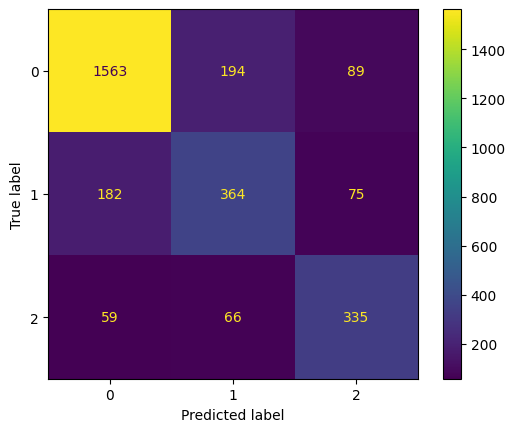

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()


ROC Curve

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


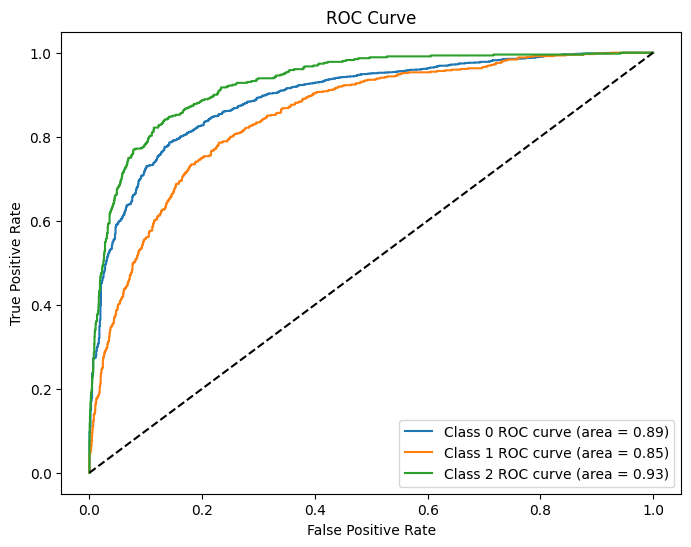

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} ROC curve (area = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Loss Curve

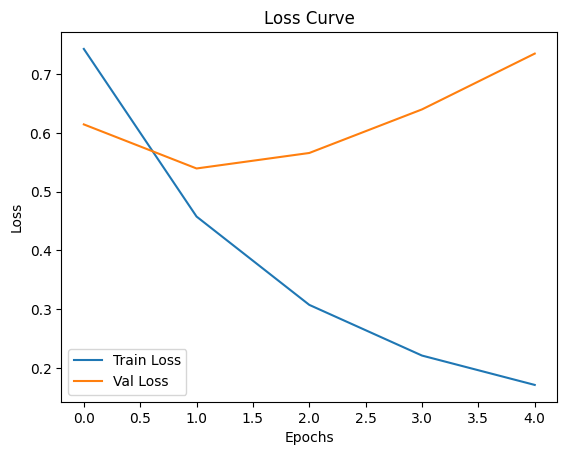

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


# **SENTIMENT ANALYSIS WITHOUT PYSPARK**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

!kaggle datasets download -d crowdflower/twitter-airline-sentiment
!unzip twitter-airline-sentiment.zip


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
Archive:  twitter-airline-sentiment.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("Tweets.csv")[['text', 'airline_sentiment']]

# Clean text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special chars
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Encode sentiment labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['airline_sentiment'])


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_text'])
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen=max_len)
y = df['label'].values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 188ms/step - accuracy: 0.6439 - loss: 0.8530 - val_accuracy: 0.7606 - val_loss: 0.6125
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.7940 - loss: 0.5101 - val_accuracy: 0.7985 - val_loss: 0.5296
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.8760 - loss: 0.3360 - val_accuracy: 0.7998 - val_loss: 0.5427
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.9147 - loss: 0.2435 - val_accuracy: 0.7896 - val_loss: 0.6230
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9315 - loss: 0.1884 - val_accuracy: 0.7896 - val_loss: 0.6650


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7968 - loss: 0.6378
Test Accuracy: 0.7920


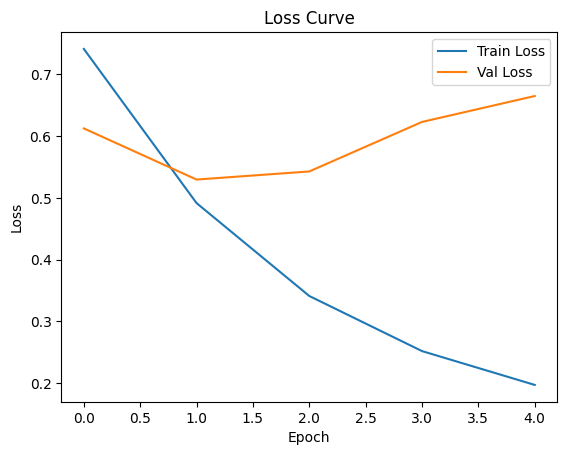

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


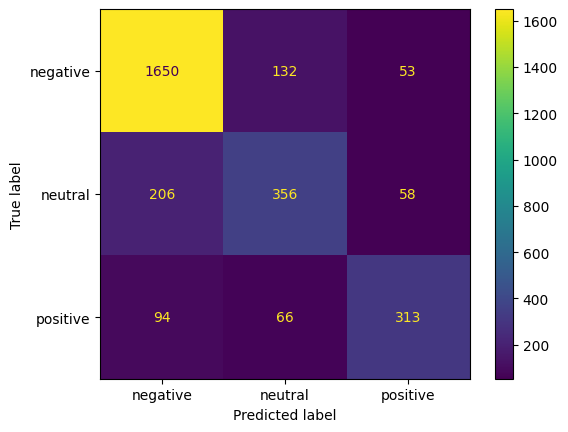

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


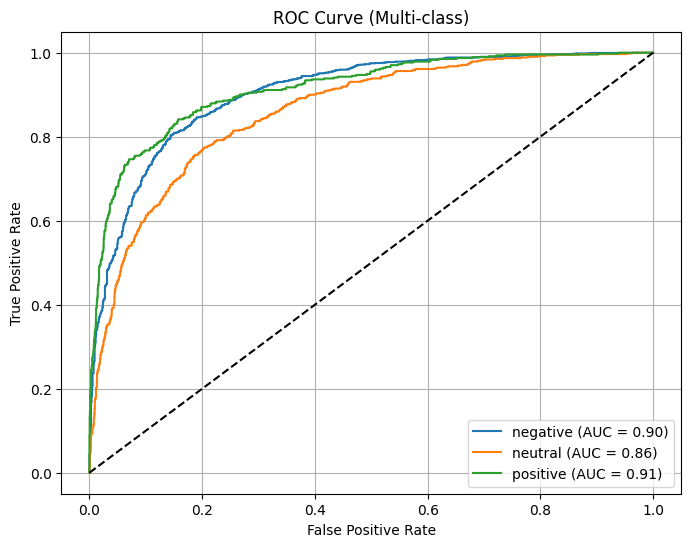

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# One-hot encode labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_probs = model.predict(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(8, 6))
for i, label in enumerate(encoder.classes_):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Multi-class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
